In [1]:
import pandas as pd
from kan.custom_processing import (plot_data_per_interval,
                                   plot_activation_and_spline_coefficients, get_masks)
import matplotlib.pyplot as plt
import os
import datetime
import json
import numpy as np

plt.rcParams['figure.figsize'] = (15, 8)
# plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 75*10

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures", "material_01")
time_stamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')

os.makedirs(save_dir, exist_ok=True)
save_heading = os.path.join(save_dir, "P3HT_" + time_stamp)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr
import torch

filepath = os.path.join(root_dir, "data", "P3HT.csv")
filedata = pd.read_csv(filepath)
name_X = filedata.columns[:-1].tolist()
name_y = filedata.columns[-1]
df_in = filedata[name_X]
df_out = filedata[[name_y]]
print(f"TARGET: {name_y}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out, rr=20)

removed_count = len(df_in) - len(df_in_final)
print(f"# of data after removing outliers: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")

X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)
print(f"Train set: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

y = df_out_final[name_y].values.reshape(-1, 1)

TARGET: Conductivity (measured) (S/cm)
# of data after removing outliers: 232 개 (1 개 제거됨)
Train set: 187 (80.6%)
Validation set: 21 (9.1%)
Test set: 24 (10.3%)


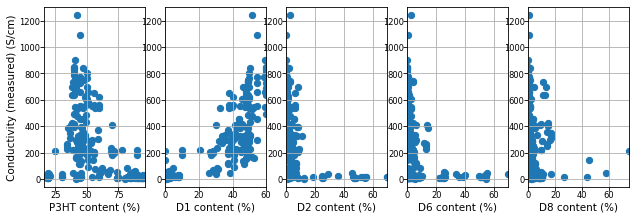

In [44]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X[:, i], y)
    ax.set_xlabel(name_X[i])
    ax.grid()
axs[0].set_ylabel(name_y)
plt.show()


| train_loss: 1.00e-01 | test_loss: 1.38e-01 | reg: 3.20e+00 | : 100%|█| 50/50 [00:05<00:00,  9.15it


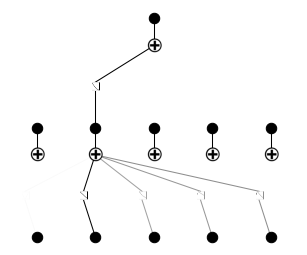

| train_loss: 6.60e-02 | test_loss: 1.50e-01 | reg: 1.23e+01 | : 100%|█| 50/50 [00:04<00:00, 11.41it
| train_loss: 6.36e-02 | test_loss: 1.86e-01 | reg: 3.50e+01 | : 100%|█| 50/50 [00:04<00:00, 11.12it
| train_loss: 4.84e-02 | test_loss: 2.24e-01 | reg: 1.34e+01 | : 100%|█| 50/50 [00:04<00:00, 10.02it
| train_loss: 4.81e-02 | test_loss: 2.14e-01 | reg: 1.19e+01 | : 100%|█| 50/50 [00:05<00:00,  9.39it


In [45]:
from kan.custom_multkan_ddp import MultKAN

def _to_tensor(x, _device):
    return torch.tensor(x, dtype=torch.float32, device=_device)

dataset = {
    'train_input': _to_tensor(X_train_norm, device),
    'train_label': _to_tensor(y_train_norm, device),
    'val_input': _to_tensor(X_val_norm, device),
    'val_label': _to_tensor(y_val_norm, device),
    'test_input': _to_tensor(X_test_norm, device),
    'test_label': _to_tensor(y_test_norm, device),
}
model = MultKAN(width=[num_input,num_input,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=50, lamb=0.002, lamb_entropy=2.)
model.plot()
plt.show()

grids = [3, 5, 10, 20]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = model.refine(grids[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())
model = model.prune(edge_th=1e-2)

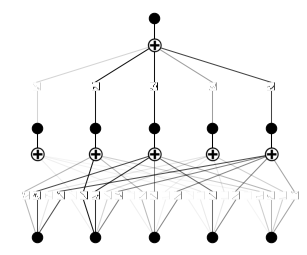

In [46]:
model.plot()

{'train': 0.9484783967178807, 'test': 0.12990088774298847}


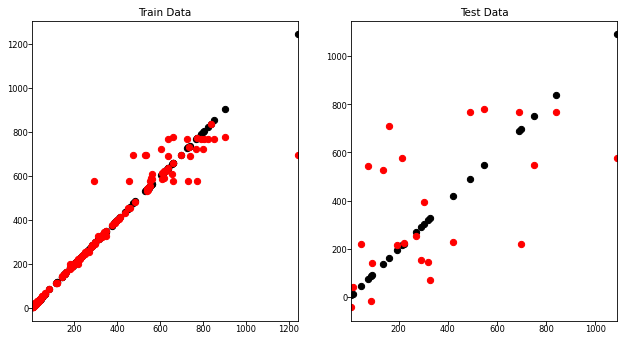

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='k')
ax_train.scatter(y_train, y_pred_train, color='r')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='k')
ax_test.scatter(y_test, y_pred_test, color='r')
ax_test.set_title("Test Data")

plt.show()
plt.show()